# ETRM Experiment Analysis

This notebook fetches all experiments from a W&B project and compares them by key metrics.

**Key Metrics Categories:**
1. **Primary Success Indicators**: train/exact_accuracy, encoder_cross_sample_var, grad/encoder_norm
2. **Secondary Indicators**: train/steps, q_halt_accuracy, lm_loss
3. **Encoder Health**: encoder output statistics
4. **Evaluation Performance**: all.exact_accuracy, ARC/pass@k

See `docs/experiment-guide.md` for detailed metric explanations.

In [1]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if abs(x) < 1000 else f'{x:.0f}')

## Configuration

In [2]:
# ============================================================================
# USER CONFIGURATION
# ============================================================================

ENTITY = "bdsaglam"
PROJECT = "etrm-semi-final-subset-eval"

# Optional: Filter runs by state
# Options: "finished", "running", "crashed", "failed", or None for all
STATE_FILTER = None

## Fetch Experiments from W&B

In [3]:
# Initialize W&B API
api = wandb.Api()

# Fetch runs
print(f"Fetching runs from {ENTITY}/{PROJECT}...")
runs = api.runs(
    f"{ENTITY}/{PROJECT}",
    filters={"state": STATE_FILTER} if STATE_FILTER else {}
)

print(f"Found {len(runs)} runs")

wandb: Currently logged in as: bdsaglam to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Fetching runs from bdsaglam/etrm-semi-final-subset-eval...
Found 10 runs


## Extract Key Metrics

We extract the **final value** (latest logged value) for each metric from each run.

In [4]:
def safe_get(d, key, default=np.nan):
    """Safely get value from dict, return default if missing."""
    try:
        val = d.get(key, default)
        return val if val is not None else default
    except:
        return default

# Extract data from runs
data = []
for run in runs:
    # Get summary (final values) and config
    summary = run.summary._json_dict
    config = {k: v for k, v in run.config.items() if not k.startswith('_')}
    
    row = {
        # Run metadata
        'name': run.name,
        'display_name': run.name if not run.name.startswith('E') else run.name,  # Short name
        'state': run.state,
        'created_at': run.created_at,
        'duration_hrs': (run.summary.get('_runtime', 0) / 3600),
        'steps': safe_get(summary, '_step', 0),
        
        # Primary Success Indicators
        'train_exact_acc': safe_get(summary, 'train/exact_accuracy') * 100,  # Convert to %
        'encoder_var': safe_get(summary, 'train/encoder_cross_sample_var'),
        'grad_encoder': safe_get(summary, 'grad/encoder_norm'),
        
        # Secondary Indicators
        'train_acc': safe_get(summary, 'train/accuracy') * 100,
        'train_steps': safe_get(summary, 'train/steps'),
        'q_halt_acc': safe_get(summary, 'train/q_halt_accuracy') * 100,
        'lm_loss': safe_get(summary, 'train/lm_loss'),
        'q_halt_loss': safe_get(summary, 'train/q_halt_loss'),
        
        # Gradient metrics
        'grad_inner': safe_get(summary, 'grad/inner_norm'),
        'grad_total': safe_get(summary, 'grad/total_norm'),
        
        # Encoder statistics
        'encoder_mean': safe_get(summary, 'train/encoder_output_mean'),
        'encoder_std': safe_get(summary, 'train/encoder_output_std'),
        'encoder_norm': safe_get(summary, 'train/encoder_output_norm'),
        'encoder_token_std': safe_get(summary, 'train/encoder_token_std'),
        
        # Evaluation metrics
        'eval_exact_acc': safe_get(summary, 'all.exact_accuracy') * 100,
        'eval_acc': safe_get(summary, 'all.accuracy') * 100,
        'arc_pass1': safe_get(summary, 'ARC/pass@1') * 100,
        'arc_pass2': safe_get(summary, 'ARC/pass@2') * 100,
        'arc_pass10': safe_get(summary, 'ARC/pass@10') * 100,
        'arc_pass1000': safe_get(summary, 'ARC/pass@1000') * 100,
        
        # Key config parameters
        'encoder_type': config.get('arch', {}).get('encoder_type', 'standard'),
        'encoder_layers': config.get('arch', {}).get('encoder_num_layers', 2),
        'halt_max_steps': config.get('arch', {}).get('halt_max_steps', 16),
        'halt_explore_prob': config.get('arch', {}).get('halt_exploration_prob', 0.5),
        'lr': config.get('optim', {}).get('learning_rate', np.nan),
        'batch_size': config.get('global_batch_size', np.nan),
    }
    data.append(row)

# Create DataFrame
df = pd.DataFrame(data)

# Sort by creation time (newest first)
df = df.sort_values('created_at', ascending=False).reset_index(drop=True)

print(f"Extracted metrics from {len(df)} runs")
print(f"\nRun states: {df['state'].value_counts().to_dict()}")

Extracted metrics from 10 runs

Run states: {'finished': 9, 'killed': 1}


## Quick Overview: All Experiments

In [5]:
# Show basic info for all runs
overview = df[[
    'display_name', 'state', 'steps', 'duration_hrs',
    'train_exact_acc', 'encoder_var', 'grad_encoder',
    'encoder_type', 'halt_max_steps', 'halt_explore_prob'
]].copy()

overview.columns = [
    'Name', 'State', 'Steps', 'Hours',
    'Train EM%', 'Enc Var', 'Grad Enc',
    'Encoder', 'Max Steps', 'Explore Prob'
]

display(overview)

,Name,State,Steps,Hours,Train EM%,Enc Var,Grad Enc,Encoder,Max Steps,Explore Prob
0,SF3_hybrid_var_baseline,finished,6970,1.4870,2.3438,2.5469,0.2178,hybrid_variational,16,0.5000
1,SF5_standard_baseline,finished,3492,0.9129,43.3594,0.0933,0.1464,standard,16,0.5000
2,SF1_hybrid_std_baseline,finished,6970,1.4852,37.5000,0.3086,0.1172,hybrid_standard,16,0.5000
3,trm_baseline,killed,1036,0.5775,0.0000,NaN,NaN,standard,16,0.1000
4,SF4_hybrid_var_explore0.7,finished,6967,1.2883,0.0000,2.2188,0.2402,hybrid_variational,16,0.7000
5,SF3_hybrid_var_baseline,finished,6967,1.2900,0.0000,2.0938,0.3848,hybrid_variational,16,0.5000
6,SF2_hybrid_std_explore0.7,finished,6967,1.2874,2.3438,0.1914,0.3652,hybrid_standard,16,0.7000
7,SF1_hybrid_std_baseline,finished,6967,1.2887,3.1250,0.2432,0.1807,hybrid_standard,16,0.5000
8,SF6_standard_explore0.7,finished,3490,0.7873,4.2969,0.2471,0.1838,standard,16,0.7000
9,SF5_standard_baseline,finished,3490,0.7864,2.7344,0.2539,0.1329,standard,16,0.5000


## Health Check Summary

Classify experiments as **Healthy**, **Warning**, or **Failed** based on key metrics:

- ✅ **Healthy**: `grad_encoder > 0.2` AND `encoder_var > 0.15`
- ⚠️ **Warning**: `grad_encoder > 0.05` OR `encoder_var > 0.1`
- ❌ **Failed**: `grad_encoder < 0.05` OR `encoder_var < 0.1`

In [6]:
def health_status(row):
    """Determine health status based on gradient flow and encoder variance."""
    grad_enc = row['grad_encoder']
    enc_var = row['encoder_var']
    
    if pd.isna(grad_enc) or pd.isna(enc_var) or isinstance(grad_enc, str) or isinstance(enc_var, str):
        return 'Unknown'
    
    # Failed: gradient starvation or collapsed encoder
    if grad_enc < 0.05 or enc_var < 0.1:
        return '❌ Failed'
    
    # Healthy: good gradients and diversity
    if grad_enc > 0.2 and enc_var > 0.15:
        return '✅ Healthy'
    
    # Warning: borderline
    return '⚠️ Warning'

df['health'] = df.apply(health_status, axis=1)

# Show health summary
print("=" * 50)
print("HEALTH CHECK SUMMARY")
print("=" * 50)
print(df['health'].value_counts())
print()

# Show problematic runs
failed_runs = df[df['health'] == '❌ Failed']
if len(failed_runs) > 0:
    print("\nFailed Runs (gradient starvation or collapsed encoder):")
    display(failed_runs[[
        'display_name', 'state', 'train_exact_acc', 
        'encoder_var', 'grad_encoder', 'encoder_type'
    ]])

warning_runs = df[df['health'] == '⚠️ Warning']
if len(warning_runs) > 0:
    print("\nWarning Runs (borderline metrics):")
    display(warning_runs[[
        'display_name', 'state', 'train_exact_acc', 
        'encoder_var', 'grad_encoder', 'encoder_type'
    ]])

HEALTH CHECK SUMMARY
health
✅ Healthy     4
⚠️ Warning    4
❌ Failed      1
Unknown       1
Name: count, dtype: int64


Failed Runs (gradient starvation or collapsed encoder):


,display_name,state,train_exact_acc,encoder_var,grad_encoder,encoder_type
1,SF5_standard_baseline,finished,43.3594,0.0933,0.1464,standard



Warning Runs (borderline metrics):


,display_name,state,train_exact_acc,encoder_var,grad_encoder,encoder_type
2,SF1_hybrid_std_baseline,finished,37.5000,0.3086,0.1172,hybrid_standard
7,SF1_hybrid_std_baseline,finished,3.1250,0.2432,0.1807,hybrid_standard
8,SF6_standard_explore0.7,finished,4.2969,0.2471,0.1838,standard
9,SF5_standard_baseline,finished,2.7344,0.2539,0.1329,standard


## Primary Metrics Comparison

Focus on the 3 most important metrics for overfit experiments.

In [7]:
df = df.dropna(
    axis=0,
    how="any",
    subset=[
        "train_exact_acc",
        "encoder_var",
        "grad_encoder",
        "grad_inner",
        "grad_total",
    ],
)

In [8]:
# Primary metrics table
primary = df[[
    'display_name', 'state', 'steps',
    'train_exact_acc', 'encoder_var', 'grad_encoder',
    'health', 'encoder_type'
]].copy()

primary.columns = [
    'Name', 'State', 'Steps',
    'Train EM%', 'Encoder Var', 'Grad Encoder',
    'Health', 'Encoder Type'
]

# Sort by train exact accuracy
primary = primary.sort_values('Train EM%', ascending=False)

print("=" * 50)
print("PRIMARY METRICS (sorted by Train Exact Match %)")
print("=" * 50)
print("\nTarget: Train EM% > 90, Encoder Var > 0.3, Grad Encoder > 0.2\n")

display(primary)

# Highlight best performer
best = primary.iloc[0]
print(f"\n🏆 Best performer: {best['Name']} with {best['Train EM%']:.1f}% exact accuracy")
print(f"   Encoder Var: {best['Encoder Var']:.3f}, Grad Encoder: {best['Grad Encoder']:.3f}")

PRIMARY METRICS (sorted by Train Exact Match %)

Target: Train EM% > 90, Encoder Var > 0.3, Grad Encoder > 0.2



,Name,State,Steps,Train EM%,Encoder Var,Grad Encoder,Health,Encoder Type
1,SF5_standard_baseline,finished,3492,43.3594,0.0933,0.1464,❌ Failed,standard
2,SF1_hybrid_std_baseline,finished,6970,37.5000,0.3086,0.1172,⚠️ Warning,hybrid_standard
8,SF6_standard_explore0.7,finished,3490,4.2969,0.2471,0.1838,⚠️ Warning,standard
7,SF1_hybrid_std_baseline,finished,6967,3.1250,0.2432,0.1807,⚠️ Warning,hybrid_standard
9,SF5_standard_baseline,finished,3490,2.7344,0.2539,0.1329,⚠️ Warning,standard
0,SF3_hybrid_var_baseline,finished,6970,2.3438,2.5469,0.2178,✅ Healthy,hybrid_variational
6,SF2_hybrid_std_explore0.7,finished,6967,2.3438,0.1914,0.3652,✅ Healthy,hybrid_standard
5,SF3_hybrid_var_baseline,finished,6967,0.0000,2.0938,0.3848,✅ Healthy,hybrid_variational
4,SF4_hybrid_var_explore0.7,finished,6967,0.0000,2.2188,0.2402,✅ Healthy,hybrid_variational



🏆 Best performer: SF5_standard_baseline with 43.4% exact accuracy
   Encoder Var: 0.093, Grad Encoder: 0.146


## Secondary Metrics: Learning Dynamics

In [9]:
secondary = df[[
    'display_name', 'state',
    'train_acc', 'train_steps', 'q_halt_acc',
    'lm_loss', 'q_halt_loss',
    'halt_max_steps', 'halt_explore_prob'
]].copy()

secondary.columns = [
    'Name', 'State',
    'Train Acc%', 'Avg Steps', 'Q-Halt Acc%',
    'LM Loss', 'Q-Halt Loss',
    'Max Steps', 'Explore Prob'
]

print("=" * 50)
print("SECONDARY METRICS: Learning Dynamics")
print("=" * 50)
print("\nTarget: Train Acc% > 90, Q-Halt Acc% > 85, LM Loss < 0.3\n")

display(secondary)

SECONDARY METRICS: Learning Dynamics

Target: Train Acc% > 90, Q-Halt Acc% > 85, LM Loss < 0.3



,Name,State,Train Acc%,Avg Steps,Q-Halt Acc%,LM Loss,Q-Halt Loss,Max Steps,Explore Prob
0,SF3_hybrid_var_baseline,finished,79.6461,8.7344,97.6562,0.6295,0.0590,16,0.5000
1,SF5_standard_baseline,finished,92.7182,4.8984,92.5781,0.2070,0.1753,16,0.5000
2,SF1_hybrid_std_baseline,finished,92.9084,5.3281,90.6250,0.1992,0.2108,16,0.5000
4,SF4_hybrid_var_explore0.7,finished,69.1203,7.0000,100.0000,1.0559,0.0011,16,0.7000
5,SF3_hybrid_var_baseline,finished,64.9084,7.0000,100.0000,1.1699,0.0006,16,0.5000
6,SF2_hybrid_std_explore0.7,finished,77.2194,7.5312,97.6562,0.6318,0.1117,16,0.7000
7,SF1_hybrid_std_baseline,finished,76.6244,8.7422,97.6562,0.6706,0.0938,16,0.5000
8,SF6_standard_explore0.7,finished,77.9718,10.8867,95.7031,0.6295,0.1049,16,0.7000
9,SF5_standard_baseline,finished,77.4374,11.0000,97.2656,0.6701,0.0784,16,0.5000


## Encoder Statistics

In [10]:
encoder_stats = df[[
    'display_name', 'state',
    'encoder_var', 'encoder_mean', 'encoder_std',
    'encoder_norm', 'encoder_token_std',
    'encoder_type', 'encoder_layers'
]].copy()

encoder_stats.columns = [
    'Name', 'State',
    'Cross-Sample Var', 'Mean', 'Std',
    'Norm', 'Token Std',
    'Type', 'Layers'
]

print("=" * 50)
print("ENCODER OUTPUT STATISTICS")
print("=" * 50)
print("\nCross-Sample Var (diversity): >0.3 is good, <0.1 is bad\n")

display(encoder_stats)

ENCODER OUTPUT STATISTICS

Cross-Sample Var (diversity): >0.3 is good, <0.1 is bad



,Name,State,Cross-Sample Var,Mean,Std,Norm,Token Std,Type,Layers
0,SF3_hybrid_var_baseline,finished,2.5469,-0.0101,4.0000,90.0000,1.5156,hybrid_variational,4
1,SF5_standard_baseline,finished,0.0933,-0.0322,1.0000,22.6250,0.2969,standard,2
2,SF1_hybrid_std_baseline,finished,0.3086,-0.0359,1.0000,22.6250,0.5430,hybrid_standard,4
4,SF4_hybrid_var_explore0.7,finished,2.2188,0.0040,3.5781,80.5000,1.4609,hybrid_variational,4
5,SF3_hybrid_var_baseline,finished,2.0938,-0.0033,3.0312,68.5000,1.4141,hybrid_variational,4
6,SF2_hybrid_std_explore0.7,finished,0.1914,-0.0226,1.0000,22.6250,0.4277,hybrid_standard,4
7,SF1_hybrid_std_baseline,finished,0.2432,0.0129,1.0000,22.6250,0.4824,hybrid_standard,4
8,SF6_standard_explore0.7,finished,0.2471,0.0371,1.0000,22.6250,0.4844,standard,2
9,SF5_standard_baseline,finished,0.2539,0.0474,1.0000,22.6250,0.4883,standard,2


## Gradient Flow Analysis

In [11]:
# Calculate gradient ratios
df['grad_enc_ratio'] = df['grad_encoder'] / df['grad_total']
df['grad_dec_ratio'] = df['grad_inner'] / df['grad_total']

gradient = df[[
    'display_name', 'state',
    'grad_encoder', 'grad_inner', 'grad_total',
    'grad_enc_ratio', 'grad_dec_ratio',
    'encoder_type'
]].copy()

gradient.columns = [
    'Name', 'State',
    'Grad Enc', 'Grad Dec', 'Grad Total',
    'Enc Ratio', 'Dec Ratio',
    'Encoder Type'
]

print("=" * 50)
print("GRADIENT FLOW ANALYSIS")
print("=" * 50)
print("\nHealthy Enc Ratio: 0.2-0.5 (encoder getting 20-50% of gradients)")
print("Gradient starvation: Enc Ratio < 0.1\n")

display(gradient)

GRADIENT FLOW ANALYSIS

Healthy Enc Ratio: 0.2-0.5 (encoder getting 20-50% of gradients)
Gradient starvation: Enc Ratio < 0.1



,Name,State,Grad Enc,Grad Dec,Grad Total,Enc Ratio,Dec Ratio,Encoder Type
0,SF3_hybrid_var_baseline,finished,0.2178,0.9760,1.0000,0.2178,0.9760,hybrid_variational
1,SF5_standard_baseline,finished,0.1464,0.9750,0.9859,0.1485,0.9889,standard
2,SF1_hybrid_std_baseline,finished,0.1172,0.9931,1.0000,0.1172,0.9931,hybrid_standard
4,SF4_hybrid_var_explore0.7,finished,0.2402,0.5902,0.6406,0.3750,0.9213,hybrid_variational
5,SF3_hybrid_var_baseline,finished,0.3848,0.9234,1.0000,0.3848,0.9234,hybrid_variational
6,SF2_hybrid_std_explore0.7,finished,0.3652,0.2427,0.4395,0.8311,0.5523,hybrid_standard
7,SF1_hybrid_std_baseline,finished,0.1807,0.2769,0.3320,0.5441,0.8340,hybrid_standard
8,SF6_standard_explore0.7,finished,0.1838,0.4058,0.4455,0.4126,0.9109,standard
9,SF5_standard_baseline,finished,0.1329,0.2375,0.2722,0.4884,0.8726,standard


## Evaluation Performance

During overfit phase, eval set = train set, so these should match training metrics.

In [12]:
evaluation = df[[
    'display_name', 'state',
    'eval_exact_acc', 'eval_acc',
    'arc_pass1', 'arc_pass2', 'arc_pass10', 'arc_pass1000',
    'train_exact_acc'  # For comparison
]].copy()

# Calculate voting benefit
evaluation['voting_benefit'] = evaluation['arc_pass1'] / evaluation['eval_exact_acc'].replace(0, np.nan)

evaluation.columns = [
    'Name', 'State',
    'Eval EM%', 'Eval Acc%',
    'Pass@1%', 'Pass@2%', 'Pass@10%', 'Pass@1000%',
    'Train EM%', 'Voting Benefit'
]

print("=" * 50)
print("EVALUATION PERFORMANCE")
print("=" * 50)
print("\nVoting Benefit: Pass@1 / Eval EM (how much voting helps)\n")

display(evaluation)

EVALUATION PERFORMANCE

Voting Benefit: Pass@1 / Eval EM (how much voting helps)



,Name,State,Eval EM%,Eval Acc%,Pass@1%,Pass@2%,Pass@10%,Pass@1000%,Train EM%,Voting Benefit
0,SF3_hybrid_var_baseline,finished,NaN,NaN,0.0000,0.0000,0.0000,0.0000,2.3438,NaN
1,SF5_standard_baseline,finished,NaN,NaN,1.0000,1.0000,1.5000,2.6250,43.3594,NaN
2,SF1_hybrid_std_baseline,finished,NaN,NaN,0.5000,0.7500,1.0000,1.7500,37.5000,NaN
4,SF4_hybrid_var_explore0.7,finished,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
5,SF3_hybrid_var_baseline,finished,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
6,SF2_hybrid_std_explore0.7,finished,NaN,NaN,0.0000,0.0000,0.0000,0.0000,2.3438,NaN
7,SF1_hybrid_std_baseline,finished,NaN,NaN,0.0000,0.0000,0.0000,0.0000,3.1250,NaN
8,SF6_standard_explore0.7,finished,NaN,NaN,0.0000,0.0000,0.0000,0.0000,4.2969,NaN
9,SF5_standard_baseline,finished,NaN,NaN,0.0000,0.0000,0.0000,0.0000,2.7344,NaN


## Visualizations

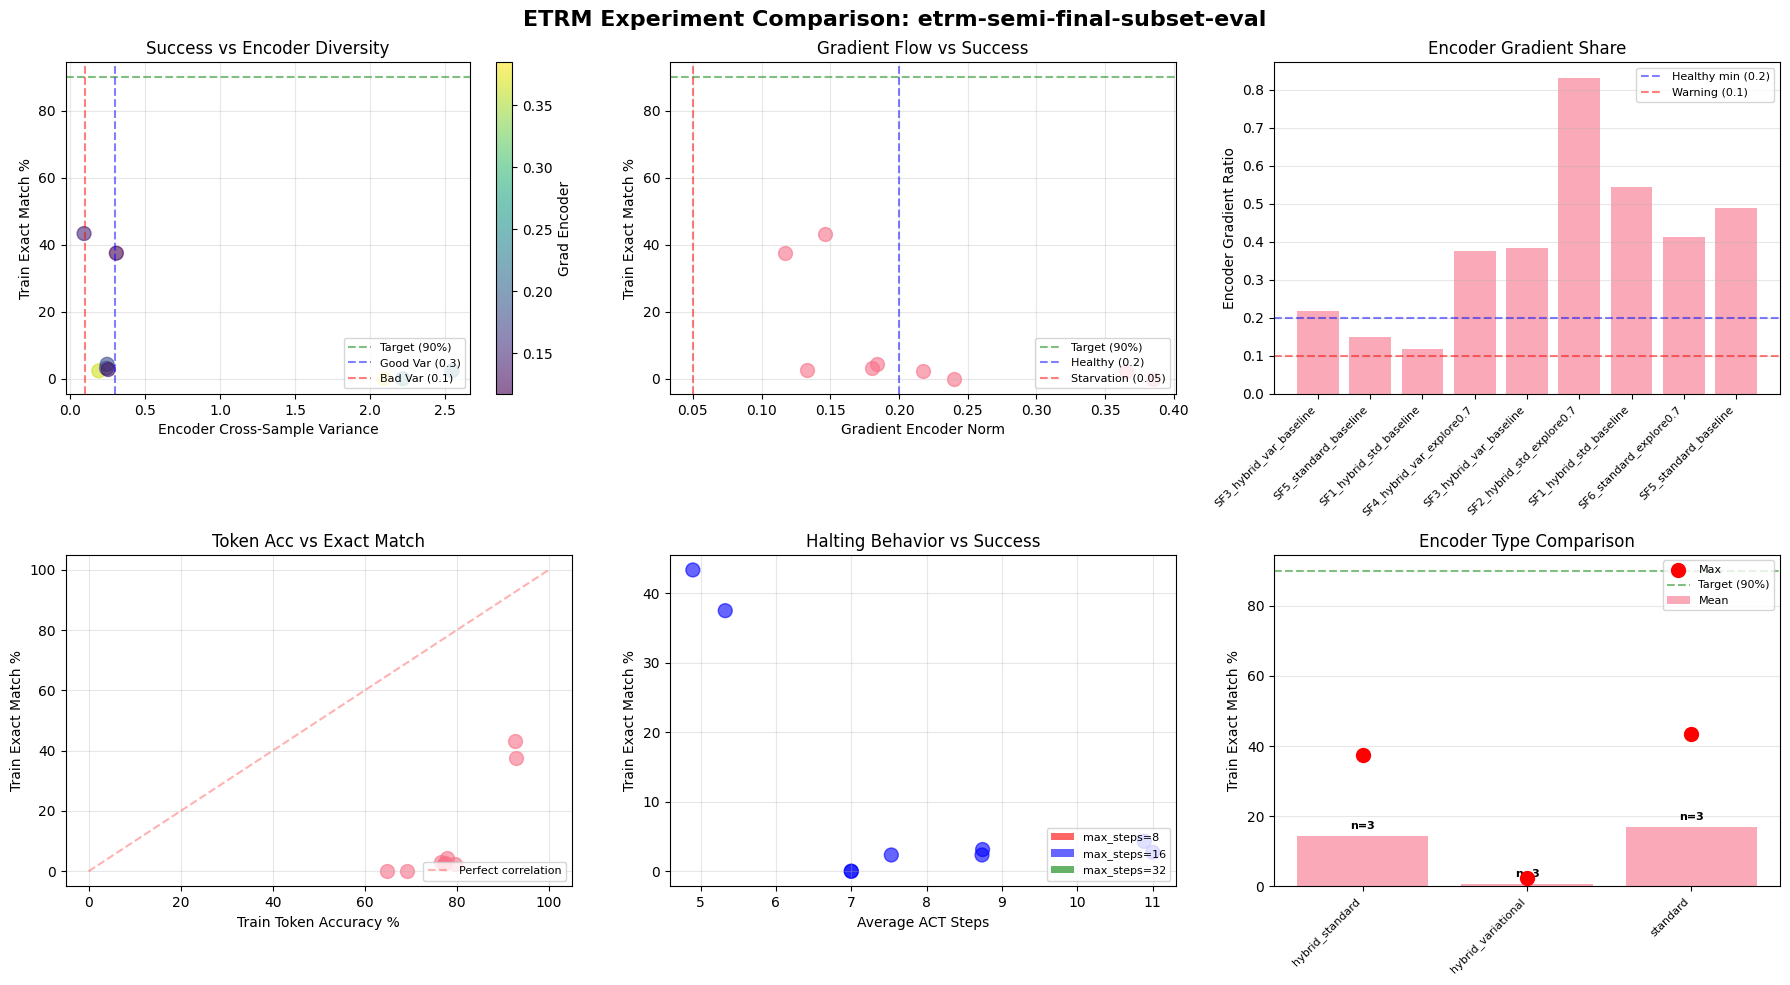

In [13]:
# Filter to runs with meaningful data
df_plot = df[df['steps'] > 0].copy()

if len(df_plot) == 0:
    print("No runs with data to plot")
else:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'ETRM Experiment Comparison: {PROJECT}', fontsize=16, fontweight='bold')
    
    # 1. Train Exact Accuracy vs Encoder Variance
    ax = axes[0, 0]
    scatter = ax.scatter(
        df_plot['encoder_var'],
        df_plot['train_exact_acc'],
        c=df_plot['grad_encoder'],
        s=100,
        alpha=0.6,
        cmap='viridis'
    )
    ax.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Target (90%)')
    ax.axvline(x=0.3, color='blue', linestyle='--', alpha=0.5, label='Good Var (0.3)')
    ax.axvline(x=0.1, color='red', linestyle='--', alpha=0.5, label='Bad Var (0.1)')
    ax.set_xlabel('Encoder Cross-Sample Variance')
    ax.set_ylabel('Train Exact Match %')
    ax.set_title('Success vs Encoder Diversity')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Grad Encoder')
    
    # 2. Gradient Encoder vs Train Accuracy
    ax = axes[0, 1]
    ax.scatter(df_plot['grad_encoder'], df_plot['train_exact_acc'], s=100, alpha=0.6)
    ax.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Target (90%)')
    ax.axvline(x=0.2, color='blue', linestyle='--', alpha=0.5, label='Healthy (0.2)')
    ax.axvline(x=0.05, color='red', linestyle='--', alpha=0.5, label='Starvation (0.05)')
    ax.set_xlabel('Gradient Encoder Norm')
    ax.set_ylabel('Train Exact Match %')
    ax.set_title('Gradient Flow vs Success')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # 3. Gradient Ratio Distribution
    ax = axes[0, 2]
    df_plot_valid = df_plot[df_plot['grad_enc_ratio'].notna()]
    if len(df_plot_valid) > 0:
        ax.bar(range(len(df_plot_valid)), df_plot_valid['grad_enc_ratio'], alpha=0.6)
        ax.axhline(y=0.2, color='blue', linestyle='--', alpha=0.5, label='Healthy min (0.2)')
        ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Warning (0.1)')
        ax.set_xticks(range(len(df_plot_valid)))
        ax.set_xticklabels(df_plot_valid['display_name'], rotation=45, ha='right', fontsize=8)
        ax.set_ylabel('Encoder Gradient Ratio')
        ax.set_title('Encoder Gradient Share')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
    
    # 4. Training Progress (Token vs Exact Accuracy)
    ax = axes[1, 0]
    ax.scatter(df_plot['train_acc'], df_plot['train_exact_acc'], s=100, alpha=0.6)
    ax.plot([0, 100], [0, 100], 'r--', alpha=0.3, label='Perfect correlation')
    ax.set_xlabel('Train Token Accuracy %')
    ax.set_ylabel('Train Exact Match %')
    ax.set_title('Token Acc vs Exact Match')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # 5. Halting Behavior
    ax = axes[1, 1]
    colors = df_plot['halt_max_steps'].map({8: 'red', 16: 'blue', 32: 'green'})
    ax.scatter(
        df_plot['train_steps'],
        df_plot['train_exact_acc'],
        c=colors,
        s=100,
        alpha=0.6
    )
    ax.set_xlabel('Average ACT Steps')
    ax.set_ylabel('Train Exact Match %')
    ax.set_title('Halting Behavior vs Success')
    ax.grid(True, alpha=0.3)
    # Add legend for max_steps
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.6, label='max_steps=8'),
        Patch(facecolor='blue', alpha=0.6, label='max_steps=16'),
        Patch(facecolor='green', alpha=0.6, label='max_steps=32')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=8)
    
    # 6. Encoder Type Comparison
    ax = axes[1, 2]
    encoder_comparison = df_plot.groupby('encoder_type')['train_exact_acc'].agg(['mean', 'max', 'count'])
    if len(encoder_comparison) > 0:
        x = range(len(encoder_comparison))
        ax.bar(x, encoder_comparison['mean'], alpha=0.6, label='Mean')
        ax.scatter(x, encoder_comparison['max'], color='red', s=100, zorder=5, label='Max')
        ax.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Target (90%)')
        ax.set_xticks(x)
        ax.set_xticklabels(encoder_comparison.index, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel('Train Exact Match %')
        ax.set_title('Encoder Type Comparison')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Annotate with counts
        for i, (idx, row) in enumerate(encoder_comparison.iterrows()):
            ax.text(i, row['mean'] + 2, f"n={int(row['count'])}", 
                   ha='center', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Configuration Comparison

Compare key hyperparameters across experiments.

In [14]:
config_comparison = df[[
    'display_name', 'state', 'train_exact_acc',
    'encoder_type', 'encoder_layers',
    'halt_max_steps', 'halt_explore_prob',
    'lr', 'batch_size'
]].copy()

config_comparison.columns = [
    'Name', 'State', 'Train EM%',
    'Encoder Type', 'Enc Layers',
    'Max Steps', 'Explore Prob',
    'LR', 'Batch Size'
]

# Sort by performance
config_comparison = config_comparison.sort_values('Train EM%', ascending=False)

print("=" * 50)
print("CONFIGURATION COMPARISON")
print("=" * 50)
print()

display(config_comparison)

CONFIGURATION COMPARISON



,Name,State,Train EM%,Encoder Type,Enc Layers,Max Steps,Explore Prob,LR,Batch Size
1,SF5_standard_baseline,finished,43.3594,standard,2,16,0.5000,NaN,256
2,SF1_hybrid_std_baseline,finished,37.5000,hybrid_standard,4,16,0.5000,NaN,128
8,SF6_standard_explore0.7,finished,4.2969,standard,2,16,0.7000,NaN,256
7,SF1_hybrid_std_baseline,finished,3.1250,hybrid_standard,4,16,0.5000,NaN,128
9,SF5_standard_baseline,finished,2.7344,standard,2,16,0.5000,NaN,256
0,SF3_hybrid_var_baseline,finished,2.3438,hybrid_variational,4,16,0.5000,NaN,128
6,SF2_hybrid_std_explore0.7,finished,2.3438,hybrid_standard,4,16,0.7000,NaN,128
5,SF3_hybrid_var_baseline,finished,0.0000,hybrid_variational,4,16,0.5000,NaN,128
4,SF4_hybrid_var_explore0.7,finished,0.0000,hybrid_variational,4,16,0.7000,NaN,128


## Pareto Frontier Analysis

Identify experiments that are **Pareto optimal** - experiments that represent the best trade-offs between multiple objectives.

An experiment is on the Pareto frontier if:
1. It's the **best** in at least one significant metric, OR
2. There's **no other experiment** that is better or equal in ALL significant metrics

**Significant Metrics** (for Pareto analysis):
- `train_exact_acc` (higher is better) - Training success metric
- `arc_pass1` (higher is better) - **Test set performance (generalization)**
- `encoder_var` (higher is better) - Encoder diversity
- `grad_encoder` (higher is better) - Gradient flow to encoder
- `lm_loss` (lower is better) - Prediction quality

These experiments represent different trade-offs and should be considered for further analysis.

**Note**: During overfit phase, test set = train set (32 groups), but `arc_pass1` uses voting which can reveal better generalization patterns.

In [15]:
def is_pareto_optimal(df, metrics_to_maximize, metrics_to_minimize):
    """
    Identify Pareto optimal solutions.
    
    An experiment is Pareto optimal if no other experiment dominates it
    (i.e., is better or equal in all objectives).
    """
    pareto_mask = np.ones(len(df), dtype=bool)
    
    for i in range(len(df)):
        if not pareto_mask[i]:
            continue
        
        # Check if experiment i is dominated by any other experiment
        for j in range(len(df)):
            if i == j or not pareto_mask[j]:
                continue
            
            # Check dominance: j dominates i if j is >= i in all maximize metrics
            # and <= i in all minimize metrics
            dominates = True
            strictly_better = False
            
            # Check maximize metrics (higher is better)
            for metric in metrics_to_maximize:
                val_i = df.iloc[i][metric]
                val_j = df.iloc[j][metric]
                
                # Handle NaN values
                if pd.isna(val_i) and pd.isna(val_j):
                    continue
                if pd.isna(val_i):
                    dominates = False
                    break
                if pd.isna(val_j):
                    continue
                
                if val_j < val_i:
                    dominates = False
                    break
                if val_j > val_i:
                    strictly_better = True
            
            if not dominates:
                continue
            
            # Check minimize metrics (lower is better)
            for metric in metrics_to_minimize:
                val_i = df.iloc[i][metric]
                val_j = df.iloc[j][metric]
                
                # Handle NaN values
                if pd.isna(val_i) and pd.isna(val_j):
                    continue
                if pd.isna(val_i):
                    dominates = False
                    break
                if pd.isna(val_j):
                    continue
                
                if val_j > val_i:
                    dominates = False
                    break
                if val_j < val_i:
                    strictly_better = True
            
            # If j dominates i and is strictly better in at least one metric
            if dominates and strictly_better:
                pareto_mask[i] = False
                break
    
    return pareto_mask

# Define metrics for Pareto analysis
metrics_to_maximize = ['train_exact_acc', 'arc_pass1', 'encoder_var', 'grad_encoder']
metrics_to_minimize = ['lm_loss']

# Filter to experiments with valid data
df_pareto = df[df['steps'] > 0].copy()

if len(df_pareto) > 0:
    # Identify Pareto optimal experiments
    pareto_mask = is_pareto_optimal(df_pareto, metrics_to_maximize, metrics_to_minimize)
    df_pareto['is_pareto'] = pareto_mask
    
    pareto_experiments = df_pareto[df_pareto['is_pareto']].copy()
    
    print("\n" + "=" * 70)
    print("PARETO FRONTIER ANALYSIS")
    print("=" * 70)
    print(f"\nFound {len(pareto_experiments)} Pareto optimal experiments out of {len(df_pareto)} total")
    print("\nThese experiments represent the best trade-offs between:")
    print("  • Train Exact Match % (maximize)")
    print("  • Test Set Pass@1 % (maximize - generalization)")
    print("  • Encoder Diversity (maximize)")
    print("  • Gradient Flow (maximize)")
    print("  • LM Loss (minimize)")
    print()
    
    # Show Pareto optimal experiments
    pareto_table = pareto_experiments[[
        'display_name', 'state',
        'train_exact_acc', 'arc_pass1', 'encoder_var', 'grad_encoder', 'lm_loss',
        'encoder_type', 'halt_max_steps', 'health'
    ]].copy()
    
    pareto_table.columns = [
        'Name', 'State',
        'Train EM%', 'Test Pass@1%', 'Enc Var', 'Grad Enc', 'LM Loss',
        'Encoder Type', 'Max Steps', 'Health'
    ]
    
    # Sort by train exact accuracy
    pareto_table = pareto_table.sort_values('Train EM%', ascending=False)
    
    display(pareto_table)
    
    # Analyze why each is on the frontier
    print("\n" + "=" * 70)
    print("WHY EACH EXPERIMENT IS ON THE PARETO FRONTIER")
    print("=" * 70)
    
    for idx, row in pareto_experiments.iterrows():
        name = row['display_name']
        reasons = []
        
        # Check if best in any metric
        for metric in metrics_to_maximize:
            if row[metric] == df_pareto[metric].max():
                metric_name = {
                    'train_exact_acc': 'Train Exact Match',
                    'arc_pass1': 'Test Pass@1 (Generalization)',
                    'encoder_var': 'Encoder Diversity',
                    'grad_encoder': 'Gradient Flow'
                }.get(metric, metric)
                reasons.append(f"Best {metric_name} ({row[metric]:.3f})")
        
        for metric in metrics_to_minimize:
            if row[metric] == df_pareto[metric].min():
                metric_name = {'lm_loss': 'LM Loss'}.get(metric, metric)
                reasons.append(f"Best {metric_name} ({row[metric]:.3f})")
        
        if reasons:
            print(f"\n✨ {name}: {', '.join(reasons)}")
        else:
            print(f"\n🔄 {name}: Optimal trade-off (not dominated by any other experiment)")
            # Show the trade-offs
            print(f"   Train EM: {row['train_exact_acc']:.1f}%, Test Pass@1: {row['arc_pass1']:.1f}%, "
                  f"Enc Var: {row['encoder_var']:.3f}, Grad Enc: {row['grad_encoder']:.3f}, LM Loss: {row['lm_loss']:.3f}")
else:
    print("No experiments with data for Pareto analysis")


PARETO FRONTIER ANALYSIS

Found 8 Pareto optimal experiments out of 9 total

These experiments represent the best trade-offs between:
  • Train Exact Match % (maximize)
  • Test Set Pass@1 % (maximize - generalization)
  • Encoder Diversity (maximize)
  • Gradient Flow (maximize)
  • LM Loss (minimize)



,Name,State,Train EM%,Test Pass@1%,Enc Var,Grad Enc,LM Loss,Encoder Type,Max Steps,Health
1,SF5_standard_baseline,finished,43.3594,1.0000,0.0933,0.1464,0.2070,standard,16,❌ Failed
2,SF1_hybrid_std_baseline,finished,37.5000,0.5000,0.3086,0.1172,0.1992,hybrid_standard,16,⚠️ Warning
8,SF6_standard_explore0.7,finished,4.2969,0.0000,0.2471,0.1838,0.6295,standard,16,⚠️ Warning
9,SF5_standard_baseline,finished,2.7344,0.0000,0.2539,0.1329,0.6701,standard,16,⚠️ Warning
6,SF2_hybrid_std_explore0.7,finished,2.3438,0.0000,0.1914,0.3652,0.6318,hybrid_standard,16,✅ Healthy
0,SF3_hybrid_var_baseline,finished,2.3438,0.0000,2.5469,0.2178,0.6295,hybrid_variational,16,✅ Healthy
4,SF4_hybrid_var_explore0.7,finished,0.0000,0.0000,2.2188,0.2402,1.0559,hybrid_variational,16,✅ Healthy
5,SF3_hybrid_var_baseline,finished,0.0000,0.0000,2.0938,0.3848,1.1699,hybrid_variational,16,✅ Healthy



WHY EACH EXPERIMENT IS ON THE PARETO FRONTIER

✨ SF3_hybrid_var_baseline: Best Encoder Diversity (2.547)

✨ SF5_standard_baseline: Best Train Exact Match (43.359), Best Test Pass@1 (Generalization) (1.000)

✨ SF1_hybrid_std_baseline: Best LM Loss (0.199)

🔄 SF4_hybrid_var_explore0.7: Optimal trade-off (not dominated by any other experiment)
   Train EM: 0.0%, Test Pass@1: 0.0%, Enc Var: 2.219, Grad Enc: 0.240, LM Loss: 1.056

✨ SF3_hybrid_var_baseline: Best Gradient Flow (0.385)

🔄 SF2_hybrid_std_explore0.7: Optimal trade-off (not dominated by any other experiment)
   Train EM: 2.3%, Test Pass@1: 0.0%, Enc Var: 0.191, Grad Enc: 0.365, LM Loss: 0.632

🔄 SF6_standard_explore0.7: Optimal trade-off (not dominated by any other experiment)
   Train EM: 4.3%, Test Pass@1: 0.0%, Enc Var: 0.247, Grad Enc: 0.184, LM Loss: 0.630

🔄 SF5_standard_baseline: Optimal trade-off (not dominated by any other experiment)
   Train EM: 2.7%, Test Pass@1: 0.0%, Enc Var: 0.254, Grad Enc: 0.133, LM Loss: 0.670

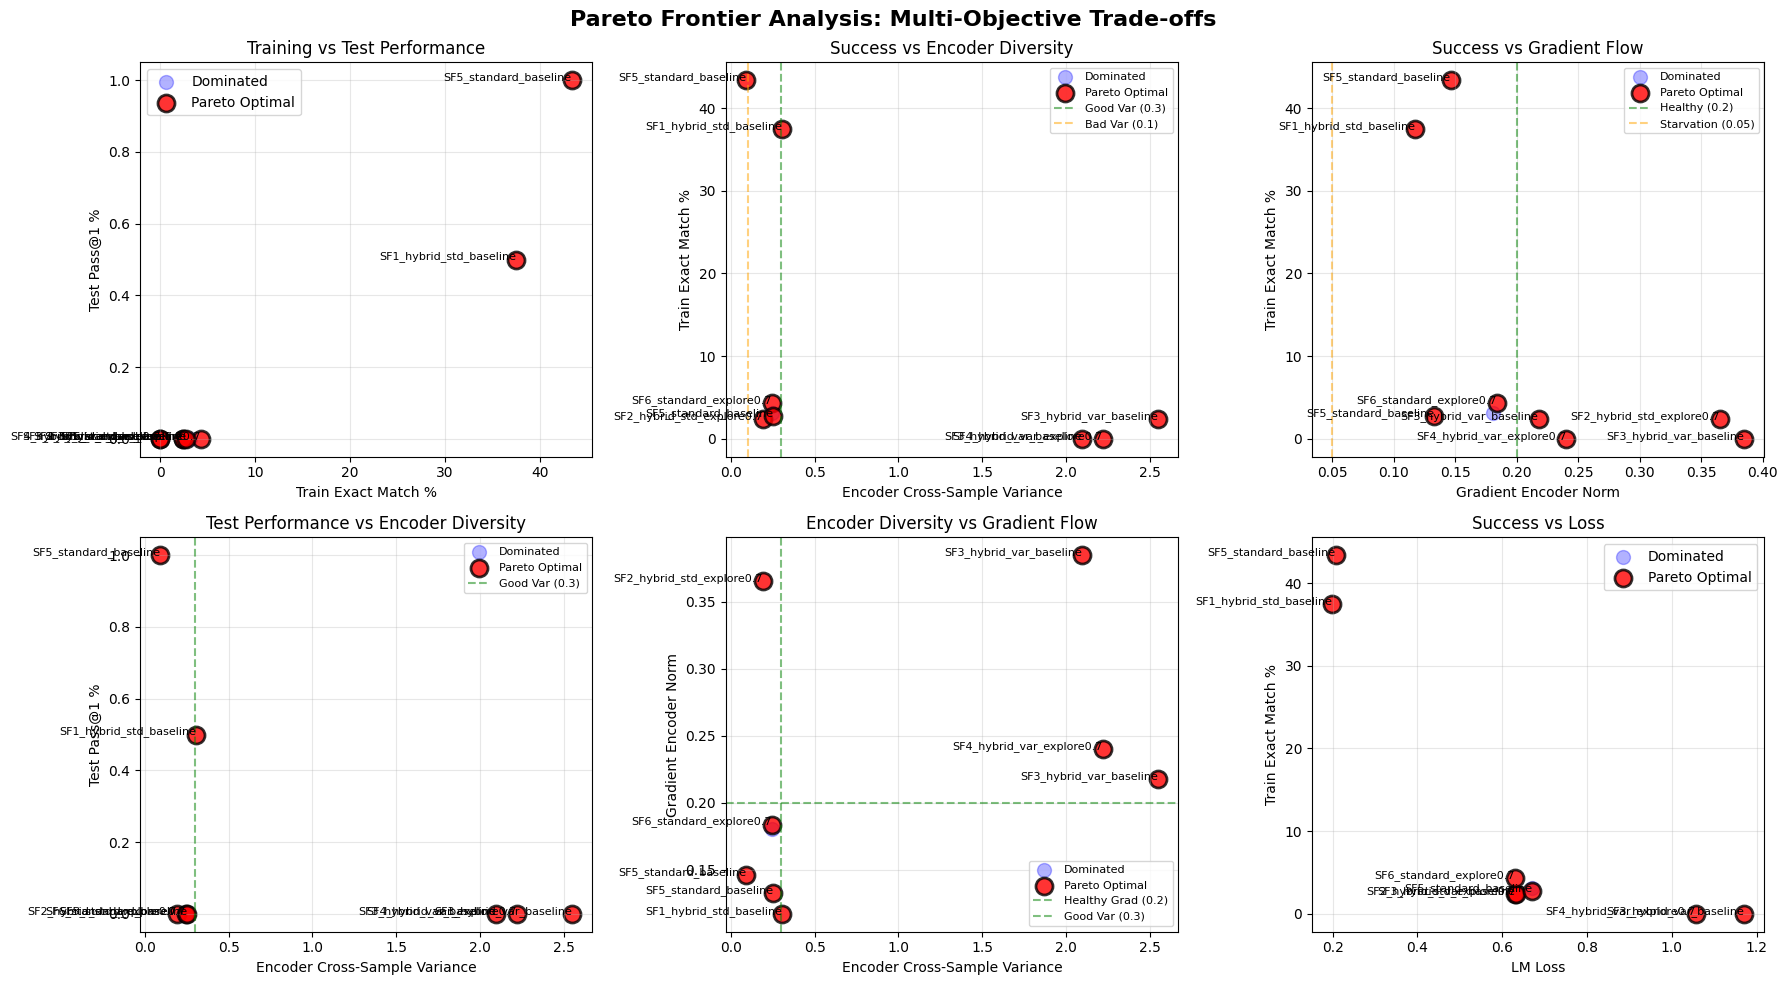


📊 INTERPRETATION NOTES:

🔴 Red points = Pareto optimal (best trade-offs)
🔵 Blue points = Dominated (there exists a better experiment in all metrics)

💡 Trade-offs to consider:
   • Training success vs Generalization: High train but low test = overfitting
   • Success vs Encoder health: High accuracy with low variance = lucky but fragile
   • Success vs Gradient flow: High accuracy with low gradients = stagnating
   • Encoder diversity vs Gradient flow: Both should be high for healthy learning


In [16]:
# Visualize Pareto frontier
if len(df_pareto) > 0 and 'is_pareto' in df_pareto.columns:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Pareto Frontier Analysis: Multi-Objective Trade-offs', fontsize=16, fontweight='bold')
    
    # Separate Pareto and dominated experiments
    pareto_exps = df_pareto[df_pareto['is_pareto']]
    dominated_exps = df_pareto[~df_pareto['is_pareto']]
    
    # Plot 1: Training vs Test Performance
    ax = axes[0, 0]
    ax.scatter(dominated_exps['train_exact_acc'], dominated_exps['arc_pass1'], 
               s=100, alpha=0.3, color='blue', label='Dominated')
    ax.scatter(pareto_exps['train_exact_acc'], pareto_exps['arc_pass1'], 
               s=150, alpha=0.8, color='red', label='Pareto Optimal', edgecolors='black', linewidth=2)
    ax.set_xlabel('Train Exact Match %')
    ax.set_ylabel('Test Pass@1 %')
    ax.set_title('Training vs Test Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Annotate Pareto points
    for idx, row in pareto_exps.iterrows():
        ax.annotate(row['display_name'], 
                   (row['train_exact_acc'], row['arc_pass1']),
                   fontsize=8, ha='right')
    
    # Plot 2: Success vs Encoder Diversity
    ax = axes[0, 1]
    ax.scatter(dominated_exps['encoder_var'], dominated_exps['train_exact_acc'], 
               s=100, alpha=0.3, color='blue', label='Dominated')
    ax.scatter(pareto_exps['encoder_var'], pareto_exps['train_exact_acc'], 
               s=150, alpha=0.8, color='red', label='Pareto Optimal', edgecolors='black', linewidth=2)
    ax.axvline(x=0.3, color='green', linestyle='--', alpha=0.5, label='Good Var (0.3)')
    ax.axvline(x=0.1, color='orange', linestyle='--', alpha=0.5, label='Bad Var (0.1)')
    ax.set_xlabel('Encoder Cross-Sample Variance')
    ax.set_ylabel('Train Exact Match %')
    ax.set_title('Success vs Encoder Diversity')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    # Annotate Pareto points
    for idx, row in pareto_exps.iterrows():
        ax.annotate(row['display_name'], 
                   (row['encoder_var'], row['train_exact_acc']),
                   fontsize=8, ha='right')
    
    # Plot 3: Success vs Gradient Flow
    ax = axes[0, 2]
    ax.scatter(dominated_exps['grad_encoder'], dominated_exps['train_exact_acc'], 
               s=100, alpha=0.3, color='blue', label='Dominated')
    ax.scatter(pareto_exps['grad_encoder'], pareto_exps['train_exact_acc'], 
               s=150, alpha=0.8, color='red', label='Pareto Optimal', edgecolors='black', linewidth=2)
    ax.axvline(x=0.2, color='green', linestyle='--', alpha=0.5, label='Healthy (0.2)')
    ax.axvline(x=0.05, color='orange', linestyle='--', alpha=0.5, label='Starvation (0.05)')
    ax.set_xlabel('Gradient Encoder Norm')
    ax.set_ylabel('Train Exact Match %')
    ax.set_title('Success vs Gradient Flow')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    # Annotate Pareto points
    for idx, row in pareto_exps.iterrows():
        ax.annotate(row['display_name'], 
                   (row['grad_encoder'], row['train_exact_acc']),
                   fontsize=8, ha='right')
    
    # Plot 4: Test Performance vs Encoder Diversity
    ax = axes[1, 0]
    ax.scatter(dominated_exps['encoder_var'], dominated_exps['arc_pass1'], 
               s=100, alpha=0.3, color='blue', label='Dominated')
    ax.scatter(pareto_exps['encoder_var'], pareto_exps['arc_pass1'], 
               s=150, alpha=0.8, color='red', label='Pareto Optimal', edgecolors='black', linewidth=2)
    ax.axvline(x=0.3, color='green', linestyle='--', alpha=0.5, label='Good Var (0.3)')
    ax.set_xlabel('Encoder Cross-Sample Variance')
    ax.set_ylabel('Test Pass@1 %')
    ax.set_title('Test Performance vs Encoder Diversity')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    # Annotate Pareto points
    for idx, row in pareto_exps.iterrows():
        ax.annotate(row['display_name'], 
                   (row['encoder_var'], row['arc_pass1']),
                   fontsize=8, ha='right')
    
    # Plot 5: Encoder Diversity vs Gradient Flow
    ax = axes[1, 1]
    ax.scatter(dominated_exps['encoder_var'], dominated_exps['grad_encoder'], 
               s=100, alpha=0.3, color='blue', label='Dominated')
    ax.scatter(pareto_exps['encoder_var'], pareto_exps['grad_encoder'], 
               s=150, alpha=0.8, color='red', label='Pareto Optimal', edgecolors='black', linewidth=2)
    ax.axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Healthy Grad (0.2)')
    ax.axvline(x=0.3, color='green', linestyle='--', alpha=0.5, label='Good Var (0.3)')
    ax.set_xlabel('Encoder Cross-Sample Variance')
    ax.set_ylabel('Gradient Encoder Norm')
    ax.set_title('Encoder Diversity vs Gradient Flow')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    # Annotate Pareto points
    for idx, row in pareto_exps.iterrows():
        ax.annotate(row['display_name'], 
                   (row['encoder_var'], row['grad_encoder']),
                   fontsize=8, ha='right')
    
    # Plot 6: Success vs Loss
    ax = axes[1, 2]
    ax.scatter(dominated_exps['lm_loss'], dominated_exps['train_exact_acc'], 
               s=100, alpha=0.3, color='blue', label='Dominated')
    ax.scatter(pareto_exps['lm_loss'], pareto_exps['train_exact_acc'], 
               s=150, alpha=0.8, color='red', label='Pareto Optimal', edgecolors='black', linewidth=2)
    ax.set_xlabel('LM Loss')
    ax.set_ylabel('Train Exact Match %')
    ax.set_title('Success vs Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Annotate Pareto points
    for idx, row in pareto_exps.iterrows():
        ax.annotate(row['display_name'], 
                   (row['lm_loss'], row['train_exact_acc']),
                   fontsize=8, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation notes
    print("\n📊 INTERPRETATION NOTES:")
    print("=" * 70)
    print("\n🔴 Red points = Pareto optimal (best trade-offs)")
    print("🔵 Blue points = Dominated (there exists a better experiment in all metrics)")
    print("\n💡 Trade-offs to consider:")
    print("   • Training success vs Generalization: High train but low test = overfitting")
    print("   • Success vs Encoder health: High accuracy with low variance = lucky but fragile")
    print("   • Success vs Gradient flow: High accuracy with low gradients = stagnating")
    print("   • Encoder diversity vs Gradient flow: Both should be high for healthy learning")
else:
    print("No data available for Pareto frontier visualization")

## Pareto Frontier Visualization

Visualize the trade-offs between different objectives for Pareto optimal experiments.

**Key Plots:**
1. **Training vs Test Performance** - Shows train/test trade-off
2. **Success vs Encoder Diversity** - Checks for encoder collapse
3. **Success vs Gradient Flow** - Identifies gradient starvation
4. **Test Performance vs Encoder Diversity** - Generalization vs representation quality
5. **Encoder Diversity vs Gradient Flow** - Encoder health correlation
6. **Success vs Loss** - Prediction quality vs exact match

## Summary & Recommendations

Based on the analysis above, generate recommendations for next experiments.

In [17]:
print("\n" + "=" * 70)
print("SUMMARY & RECOMMENDATIONS")
print("=" * 70)

# Overall stats
total_runs = len(df)
finished_runs = len(df[df['state'] == 'finished'])
successful_runs = len(df[df['train_exact_acc'] >= 90])
healthy_runs = len(df[df['health'] == '✅ Healthy'])

print(f"\n📊 Overall Statistics:")
print(f"   Total runs: {total_runs}")
print(f"   Finished: {finished_runs}")
print(f"   Successful (≥90% train EM): {successful_runs}")
print(f"   Healthy (good gradients & variance): {healthy_runs}")

# Best run
if len(df) > 0:
    best_run = df.loc[df['train_exact_acc'].idxmax()]
    print(f"\n🏆 Best Run: {best_run['display_name']}")
    print(f"   Train Exact Match: {best_run['train_exact_acc']:.1f}%")
    print(f"   Encoder Type: {best_run['encoder_type']}")
    print(f"   Encoder Variance: {best_run['encoder_var']:.3f}")
    print(f"   Gradient Encoder: {best_run['grad_encoder']:.3f}")
    print(f"   Health Status: {best_run['health']}")

# Encoder type analysis
print(f"\n🔧 Encoder Type Analysis:")
encoder_perf = df.groupby('encoder_type').agg({
    'train_exact_acc': ['mean', 'max', 'count']
}).round(2)
for encoder_type in encoder_perf.index:
    mean_acc = encoder_perf.loc[encoder_type, ('train_exact_acc', 'mean')]
    max_acc = encoder_perf.loc[encoder_type, ('train_exact_acc', 'max')]
    count = int(encoder_perf.loc[encoder_type, ('train_exact_acc', 'count')])
    print(f"   {encoder_type}: mean={mean_acc:.1f}%, max={max_acc:.1f}% (n={count})")

# Problem detection
print(f"\n⚠️ Issues Detected:")
gradient_starved = df[df['grad_encoder'] < 0.05]
if len(gradient_starved) > 0:
    print(f"   Gradient starvation: {len(gradient_starved)} runs")
    print(f"      → {', '.join(gradient_starved['display_name'].tolist())}")

collapsed_encoder = df[df['encoder_var'] < 0.1]
if len(collapsed_encoder) > 0:
    print(f"   Collapsed encoder: {len(collapsed_encoder)} runs")
    print(f"      → {', '.join(collapsed_encoder['display_name'].tolist())}")

not_improving = df[(df['state'] == 'finished') & (df['train_exact_acc'] < 50)]
if len(not_improving) > 0:
    print(f"   Failed to learn: {len(not_improving)} runs")
    print(f"      → {', '.join(not_improving['display_name'].tolist())}")

# Recommendations
print(f"\n💡 Recommendations:")

if successful_runs == 0:
    print("   ❌ No successful runs yet (>90% train EM)")
    print("   → Continue training existing runs or investigate issues")
elif successful_runs > 0:
    print(f"   ✅ {successful_runs} successful run(s) found!")
    print("   → Ready for Phase 2 (full dataset training)")

if len(gradient_starved) > 0:
    print("   → Gradient starvation detected: check encoder architecture and loss computation")

if len(collapsed_encoder) > 0:
    print("   → Collapsed encoder detected: encoder not learning diverse representations")

# Best configuration to continue
if len(df[df['health'] == '✅ Healthy']) > 0:
    healthy_df = df[df['health'] == '✅ Healthy'].sort_values('train_exact_acc', ascending=False)
    best_healthy = healthy_df.iloc[0]
    print(f"\n✨ Best Configuration to Continue:")
    print(f"   Encoder: {best_healthy['encoder_type']}")
    print(f"   Layers: {best_healthy['encoder_layers']}")
    print(f"   Max steps: {best_healthy['halt_max_steps']}")
    print(f"   Explore prob: {best_healthy['halt_explore_prob']}")
    print(f"   Current performance: {best_healthy['train_exact_acc']:.1f}%")

print("=" * 70)


SUMMARY & RECOMMENDATIONS

📊 Overall Statistics:
   Total runs: 9
   Finished: 9
   Successful (≥90% train EM): 0
   Healthy (good gradients & variance): 4

🏆 Best Run: SF5_standard_baseline
   Train Exact Match: 43.4%
   Encoder Type: standard
   Encoder Variance: 0.093
   Gradient Encoder: 0.146
   Health Status: ❌ Failed

🔧 Encoder Type Analysis:
   hybrid_standard: mean=14.3%, max=37.5% (n=3)
   hybrid_variational: mean=0.8%, max=2.3% (n=3)
   standard: mean=16.8%, max=43.4% (n=3)

⚠️ Issues Detected:
   Collapsed encoder: 1 runs
      → SF5_standard_baseline
   Failed to learn: 9 runs
      → SF3_hybrid_var_baseline, SF5_standard_baseline, SF1_hybrid_std_baseline, SF4_hybrid_var_explore0.7, SF3_hybrid_var_baseline, SF2_hybrid_std_explore0.7, SF1_hybrid_std_baseline, SF6_standard_explore0.7, SF5_standard_baseline

💡 Recommendations:
   ❌ No successful runs yet (>90% train EM)
   → Continue training existing runs or investigate issues
   → Collapsed encoder detected: encoder not le

## Export Results

Save the comparison table for reference.

In [18]:
# Export to CSV
import os

output_file = f"./results/{PROJECT}_comparison.csv"
os.makedirs("./results", exist_ok=True)

df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

Results saved to: ./results/etrm-semi-final-subset-eval_comparison.csv
